In [1]:
from mpl_toolkits.basemap import Basemap, cm
import os.path
import sys
from matplotlib import rcParams
from matplotlib.animation import ArtistAnimation
import matplotlib
import matplotlib.pyplot as plt
import pyart
%matplotlib inline
from siphon.radarserver import RadarServer
rs = RadarServer('http://thredds-aws.unidata.ucar.edu/thredds/radarServer/nexrad/level2/S3/')
#rs = RadarServer('http://thredds.ucar.edu/thredds/radarServer/nexrad/level2/IDD/')
from datetime import datetime, timedelta
from siphon.cdmr import Dataset
import pyart
import numpy as np
import numpy.ma as ma
import netCDF4
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy.ma as ma
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
from metpy.plots import StationPlot
from metpy.plots.wx_symbols import sky_cover
from metpy.calc import get_wind_components
from metpy.units import units
from IPython.display import HTML


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



C:\Users\matts\Miniconda3\envs\devel\lib\site-packages\babel\plural.py:301: DeprecationWarning: Flags not at the start of the expression \s+(?u)
  (None, re.compile(r'\s+(?u)')),


(-98.325555555555553, 46.527777777777779, <cartopy.crs.PlateCarree object at 0x00000248E023AEB8>)
(-98.325555555555553, 46.527777777777779, <cartopy.crs.PlateCarree object at 0x0000024880A9F570>)


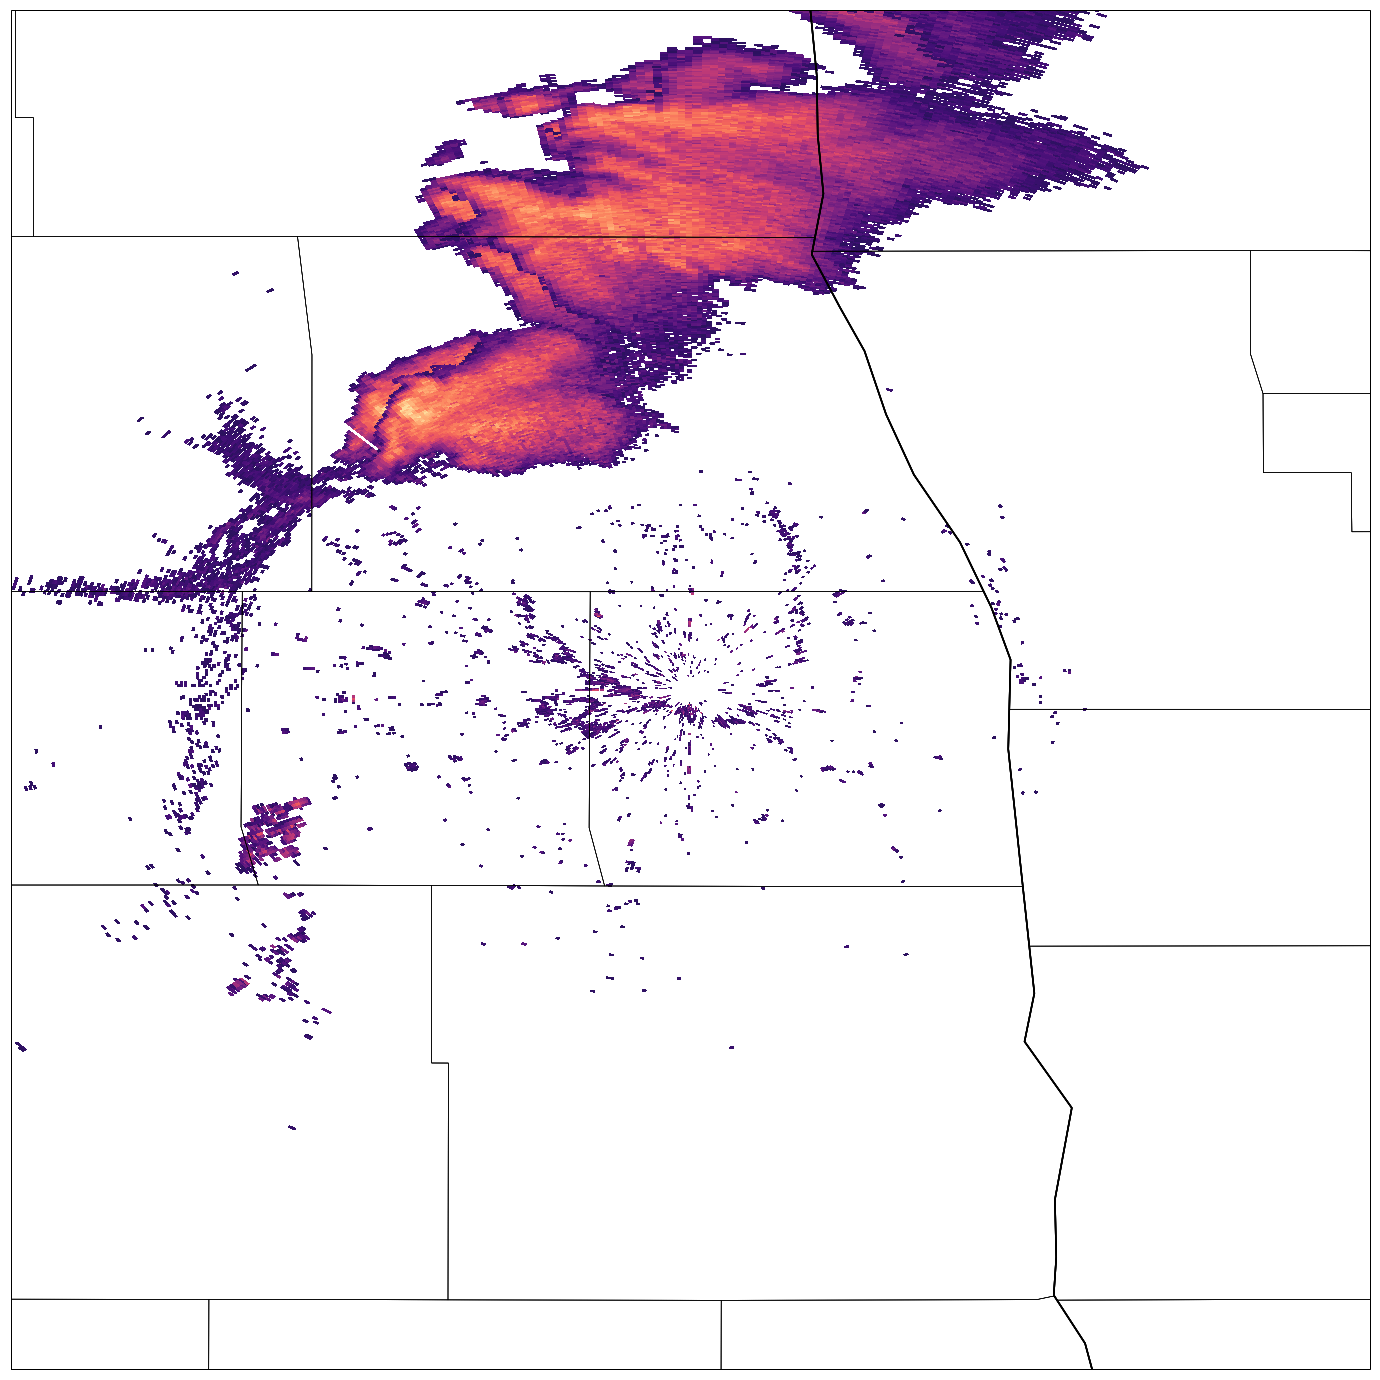

In [6]:

artists = []

query = rs.query()
#Here, set the initial time of the archived radar loop you want.
dt = datetime(2017, 7, 11, 23, 0) # Our specified time
query.stations('KMVX').time_range(dt, dt + timedelta(hours=.1))
cat = rs.get_catalog(query)
cat.datasets
f = 27
n = 0
for item in sorted(cat.datasets.items()):
    try:
        # After looping over the list of sorted datasets, pull the actual Dataset object out
        # of our list of items and access over CDMRemote
        ds = item[1]
        radar = pyart.io.nexrad_cdm.read_nexrad_cdm(ds.access_urls['OPENDAP'])
        #radar = pyart.io.read_nexrad_archive(ds.access_urls['CdmRemote'])
        #radar = pyart.io.nexrad_cdm.read_nexrad_cdm(ds.access_urls['CdmRemote'])
        #data = Dataset(ds.access_urls['CdmRemote'])
        time_start = netCDF4.num2date(radar.time['data'][0], radar.time['units'])
        #Now let's calculate and plot specific differential phase.
        radar = radar.extract_sweeps([0])
        kdp_dict = pyart.retrieve.kdp_proc.kdp_maesaka(radar)
        radar.add_field('KDP', kdp_dict[0])
        rlons = radar.gate_longitude['data']
        rlats = radar.gate_latitude['data']
        cenlat = radar.latitude['data'][0]
        cenlon = radar.longitude['data'][0]
        if n ==0: 
            #Create a figure to plot our radar and stations on
            #Let's set up the map projection!
            # Set up our projection
            crs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)

            # Set up our array of latitude and longitude values and transform to 
            # the desired projection.

            tlatlons = crs.transform_points(ccrs.LambertConformal(central_longitude=265, central_latitude=25, standard_parallels=(25.,25.)),rlons,rlats)
            tlons = tlatlons[:,:,0]
            tlats = tlatlons[:,:,1]

            # Limit the extent of the map area, must convert to proper coords.
            LL = (cenlon-1.,cenlat-1.,ccrs.PlateCarree())
            UR = (cenlon+1.,cenlat+1.0,ccrs.PlateCarree())
            print(LL)

            # Get data to plot state and province boundaries
            states_provinces = cfeature.NaturalEarthFeature(
                    category='cultural',
                    name='admin_1_states_provinces_lakes',
                    scale='50m',
                    facecolor='none')
            fname = 'cb_2016_us_county_20m/cb_2016_us_county_20m.shp'
            fname2 = 'cb_2016_us_state_20m/cb_2016_us_state_20m.shp'
            counties = ShapelyFeature(Reader(fname).geometries(),ccrs.PlateCarree(), facecolor = 'none', edgecolor = 'black')
            states = ShapelyFeature(Reader(fname2).geometries(),ccrs.PlateCarree(), facecolor = 'none', edgecolor = 'black')
            fig=plt.figure(1,figsize=(30.,25.))
            ax = plt.subplot(111,projection=ccrs.PlateCarree())
            ax.coastlines('50m',edgecolor='black',linewidth=0.75)
            #ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)
            ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
            ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
            ax.set_extent([LL[0],UR[0],LL[1],UR[1]])

        refl = radar.fields['reflectivity']['data']
        kdp = radar.fields['KDP']['data']
        zdr = radar.fields['differential_reflectivity']['data']
        refl_c = np.copy(refl)
        zdr_c = np.copy(zdr)
        kdp_c = np.copy(kdp)
        refl_c = ma.masked_less(refl_c, 20.)
        zdr_c = ma.masked_where(refl_c < 20., zdr_c)
        zdr_c = ma.masked_less(zdr_c, 3.)
        #zdr_sm = ndimage.gaussian_filter(zdr_c, sigma=1, order=0)
        kdp_c = ma.masked_where(refl_c < 20., kdp_c)
        kdp_c = ma.masked_less(kdp_c, 1.5)
        #kdp_sm = ndimage.gaussian_filter(kdp_c, sigma=1, order=0)
        refp = ax.pcolormesh(rlons, rlats, refl_c, cmap=plt.cm.magma, vmin = 10, vmax = 70)
        #Create contour levels for zdr and kdp
        zdrlev = np.arange(3., np.max(zdr_c).magnitude+((np.max(zdr_c).magnitude)-3.)/2, (np.max(zdr_c).magnitude)-3.)
        zdrclev = [3.]
        #kdpclev = [1.5]
        #kdplev = np.arange(1.5, np.max(kdp_c).magnitude+((np.max(kdp_c).magnitude)-1.5)/2, (np.max(kdp_c).magnitude)-1.5)
        #zdrp = ax.pcolormesh(rlons, rlats, zdr_c, cmap=plt.cm.cool, vmin = 3, vmax = 10, alpha = .4)
        kdpp = ax.pcolormesh(rlons, rlats, kdp_c, cmap=plt.cm.viridis, vmin = .5, vmax = 4, alpha = .4)
        #zdr_cm = ax.contourf(rlons, rlats, zdr_sm,zdrlev,colors = 'cyan', alpha = .7)
        zdr_ct = ax.contour(rlons, rlats, zdr_c,zdrclev,colors = 'cyan', linewidths = 2)
        #kdp_cm = ax.contourf(rlons, rlats, kdp_sm,kdplev,colors = 'green', alpha = .7)
        #kdp_ct = ax.contour(rlons, rlats, kdp_sm,kdpclev,colors = 'green', linewidths = 2)
              
        # copied from the browser url box
        #metar_cat_url = 'http://thredds.ucar.edu/thredds/catalog/nws/metar/ncdecoded/catalog.xml?dataset=nws/metar/ncdecoded/Metar_Station_Data_fc.cdmr'
        #metar_cat_url = 'http://thredds-test.unidata.ucar.edu/thredds/catalog/nws/metar/ncdecoded/catalog.xml?dataset=nws/metar/ncdecoded/Metar_Station_Data_fc.cdmr'
        #metar_cat_url = 'http://thredds-test.unidata.ucar.edu/thredds/catalog/nws/synoptic/ncdecoded/catalog.html?dataset=nws/synoptic/ncdecoded/Surface_Synoptic_Point_Data_fc.cdmr'
        # Parse the xml
        #catalog = TDSCatalog(metar_cat_url)
        #metar_dataset = catalog.datasets['Feature Collection']
        #ncss_url = metar_dataset.access_urls['NetcdfSubset']
        # Import ncss client
        #ncss = NCSS(ncss_url)
        # get current date and time
        #now = datetime.utcnow()
        #now = datetime(time_start.year, time_start.month, time_start.day, time_start.hour, time_start.minute)

        # define the time range we are interested in
        #start_time = now
        #end_time = now - timedelta(days=20)


        #query = ncss.query()
        #query.lonlat_box(north=cenlat+1., south=cenlat-1., east=cenlon+1., west=cenlon-1)
        #query.time(start_time)
        #query.variables('air_temperature', 'dew_point_temperature', 'inches_ALTIM',
        #                'wind_speed', 'wind_from_direction', 'cloud_area_fraction')
        #query.accept('csv')
        #data = ncss.get_data(query)

        # Access is just like netcdf4-python
        #lats = data['latitude'][:]
        #lons = data['longitude'][:]
        #tair = data['air_temperature'][:] * units('degC')
        #dewp = data['dew_point_temperature'][:] * units('degC')
        #tair = tair.to('degF').magnitude
        #dewp = dewp.to('degF').magnitude
        #slp = (data['inches_ALTIM'][:] * units('inHg')).to('mbar')

        # Convert wind to components
        #u, v = get_wind_components(data['wind_speed'], data['wind_from_direction'] * units.degree)

        # Need to handle missing (NaN) and convert to proper code
        #cloud_cover = 8 * data['cloud_area_fraction']
        #cloud_cover[np.isnan(cloud_cover)] = 10
        #cloud_cover = cloud_cover.astype(np.int)

        # For some reason these come back as bytes instead of strings
        #stid = np.array([s.decode() for s in data['station']])
        # Create a station plot pointing to an Axes to draw on as well as the location of points
        #stnp = stationplot = StationPlot(ax, lons, lats, transform=ccrs.PlateCarree(),
        #                          fontsize=12)
        #stnt = stationplot.plot_parameter('NW', tair, color='red')
        #stnd = stationplot.plot_parameter('SW', dewp, color='darkgreen')
        #stnpr = stationplot.plot_parameter('NE', slp)

        # Add wind barbs
        #stnpb = stationplot.plot_barb(u, v)

        # Plot the sky cover symbols in the center. We give it the integer code values that
        # should be plotted, as well as a mapping class that can convert the integer values
        # to the appropriate font glyph.
        #stns = stationplot.plot_symbol('C', cloud_cover, sky_cover)

        # Plot station id -- using an offset pair instead of a string location
        #stntx = stationplot.plot_text((2, 0), stid)
        title_plot = plt.title('Radar Reflectivity, ZDR, and KDP '+str(time_start.year)+'-'+str(time_start.month)+'-'+str(time_start.day)+
                               ' '+str(time_start.hour)+':'+str(time_start.minute)+' UTC', size = 25)
        plt.tight_layout()
        artists.append((refp, zdrp, kdpp, title_plot,))
        plt.show()
    except:
        continue
    #if time_start.minute < 10:
        #plt.savefig('RadarStations'+str(time_start.year)+str(time_start.month)+str(time_start.day)+str(time_start.hour)+'0'+str(time_start.minute)+'.png')
    #else:
        #plt.savefig('RadarStations'+str(time_start.year)+str(time_start.month)+str(time_start.day)+str(time_start.hour)+str(time_start.minute)+'.png')
    #n=n+1



In [5]:
%matplotlib inline
plt.show()

In [ ]:
rlons = radar.gate_longitude['data']
rlats = radar.gate_latitude['data']
refl = radar.fields['reflectivity']['data']
kdp = radar.fields['KDP']['data']
zdr = radar.fields['differential_reflectivity']['data']
cenlat = radar.latitude['data'][0]
cenlon = radar.longitude['data'][0]

print(radar.gate_longitude['data'].shape)
print(radar.gate_latitude['data'].shape)
print(radar.fields['reflectivity']['data'].shape)
print(refl)

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [ ]:
#Let's set up the map projection!
# Set up our projection
crs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)

# Set up our array of latitude and longitude values and transform to 
# the desired projection.

tlatlons = crs.transform_points(ccrs.LambertConformal(central_longitude=265, central_latitude=25, standard_parallels=(25.,25.)),rlons,rlats)
tlons = tlatlons[:,:,0]
tlats = tlatlons[:,:,1]

# Limit the extent of the map area, must convert to proper coords.
LL = (cenlon-2,cenlat-2,ccrs.PlateCarree())
UR = (cenlon+2,cenlat+2.0,ccrs.PlateCarree())
print(LL)

# Get data to plot state and province boundaries
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lakes',
        scale='50m',
        facecolor='none')

In [ ]:
import numpy.ma as ma
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

In [ ]:
fname = 'cb_2016_us_county_20m/cb_2016_us_county_20m.shp'
fname2 = 'cb_2016_us_state_20m/cb_2016_us_state_20m.shp'
counties = ShapelyFeature(Reader(fname).geometries(),ccrs.PlateCarree(), facecolor = 'none', edgecolor = 'black')
states = ShapelyFeature(Reader(fname2).geometries(),ccrs.PlateCarree(), facecolor = 'none', edgecolor = 'black')

In [ ]:
refl_m = ma.filled(refl, fill_value = np.nan)
refl_c = np.copy(refl)
zdr_c = np.copy(zdr)
kdp_c = np.copy(kdp)
refl_c1 = np.copy(refl)
refl_c = ma.masked_less(refl_c, 20.)
zdr_c = ma.masked_where(refl_c < 20., zdr_c)
zdr_c = ma.masked_less(zdr_c, 3.)
kdp_c = ma.masked_where(refl_c < 20., kdp_c)
kdp_c = ma.masked_less(kdp_c, 1.5)

In [ ]:

fig=plt.figure(1,figsize=(30.,25.))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
#ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)
ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
ax.set_extent([LL[0],UR[0],LL[1],UR[1]])
ax.pcolormesh(rlons, rlats, refl_c, cmap=plt.cm.magma, vmin = 10, vmax = 70)
ax.pcolormesh(rlons, rlats, zdr_c, cmap=plt.cm.cool, vmin = 3, vmax = 10, alpha = .4)
ax.pcolormesh(rlons, rlats, kdp_c, cmap=plt.cm.viridis, vmin = .5, vmax = 4, alpha = .4)
plt.show()

In [ ]:
from siphon.catalog import TDSCatalog

# copied from the browser url box
metar_cat_url = 'http://thredds.ucar.edu/thredds/catalog/nws/metar/ncdecoded/catalog.xml?dataset=nws/metar/ncdecoded/Metar_Station_Data_fc.cdmr'

# Parse the xml
catalog = TDSCatalog(metar_cat_url)
metar_dataset = catalog.datasets['Feature Collection']
ncss_url = metar_dataset.access_urls['NetcdfSubset']
# Import ncss client
from siphon.ncss import NCSS
ncss = NCSS(ncss_url)
# get current date and time
from datetime import datetime, timedelta
#now = datetime.utcnow()
now = datetime(2017, 6, 12, 22)

# define the time range we are interested in
start_time = dt
#end_time = now - timedelta(days=20)


query = ncss.query()
query.lonlat_box(north=cenlat+2., south=cenlat-2., east=cenlon+2., west=cenlon-2)
query.time(start_time)
query.variables('air_temperature', 'dew_point_temperature', 'inches_ALTIM',
                'wind_speed', 'wind_from_direction', 'cloud_area_fraction')
query.accept('csv')

In [ ]:
from metpy.calc import get_wind_components
from metpy.units import units

data = ncss.get_data(query)

# Access is just like netcdf4-python
lats = data['latitude'][:]
lons = data['longitude'][:]
tair = data['air_temperature'][:] * units('degC')
dewp = data['dew_point_temperature'][:] * units('degC')
tair = tair.to('degF').magnitude
dewp = dewp.to('degF').magnitude
slp = (data['inches_ALTIM'][:] * units('inHg')).to('mbar')

# Convert wind to components
u, v = get_wind_components(data['wind_speed'], data['wind_from_direction'] * units.degree)

# Need to handle missing (NaN) and convert to proper code
cloud_cover = 8 * data['cloud_area_fraction']
cloud_cover[np.isnan(cloud_cover)] = 10
cloud_cover = cloud_cover.astype(np.int)

# For some reason these come back as bytes instead of strings
stid = np.array([s.decode() for s in data['station']])

In [ ]:
from metpy.plots import StationPlot
from metpy.plots.wx_symbols import sky_cover

In [ ]:
fig=plt.figure(1,figsize=(30.,25.))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
#ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)
ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
ax.set_extent([LL[0],UR[0],LL[1],UR[1]])
ax.pcolormesh(rlons, rlats, refl_c, cmap=plt.cm.magma, vmin = 10, vmax = 70)
ax.pcolormesh(rlons, rlats, zdr_c, cmap=plt.cm.cool, vmin = 3, vmax = 10, alpha = .4)
ax.pcolormesh(rlons, rlats, kdp_c, cmap=plt.cm.viridis, vmin = .5, vmax = 4, alpha = .4)

# Create a station plot pointing to an Axes to draw on as well as the location of points
stationplot = StationPlot(ax, lons, lats, transform=ccrs.PlateCarree(),
                          fontsize=12)
stationplot.plot_parameter('NW', tair, color='red')
stationplot.plot_parameter('SW', dewp, color='darkgreen')
stationplot.plot_parameter('NE', slp)

# Add wind barbs
stationplot.plot_barb(u, v)

# Plot the sky cover symbols in the center. We give it the integer code values that
# should be plotted, as well as a mapping class that can convert the integer values
# to the appropriate font glyph.
stationplot.plot_symbol('C', cloud_cover, sky_cover)

# Plot station id -- using an offset pair instead of a string location
stationplot.plot_text((2, 0), stid)
plt.show()

In [17]:
anim = ArtistAnimation(fig, artists, interval=200., blit=False)
HTML(anim.to_html5_video())    

In [18]:
anim.save('Radar_Loop.mp4', bitrate=2500)

In [13]:
print(artists)

[]
